# Análisis de los contratos colombianos

El objeto de este notebook es mediante un ejemplo pŕactico poder realizar la aplicación de diferentes tecnologías para procesamiento y análisis de datos, usando datos públicos de un portal colombiano de contratación.

# Contexto del problema

No pretendo iniciar la discusión de si un lenguaje es mejor que otro, mi opinión es que siplemente cada herramienta esta construida para diferentes propósitos y cada quien elije la mejor que se adecue a su contexto y realidad, teniendo en cuenta lo anterior, escribo este notebook porque hace un par de meses no logré analizar el datapump generado por la herramienta: [Contra](https://github.com/dav009/contra), estaba haciendo uso del lenguaje R, pero por los recursos de mi máquina y teniendo en cuenta que R todo lo sube a memoria no logré realizar el análisis, ahora luego experimenté con Spark y logré el objetivo del procesamiento de los datos.

Es muy importante brindar los créditos a [David Przybilla](https://github.com/dav009/) porque debido a la herramienta [Contra](https://github.com/dav009/contra) es posible contar con este datapump el cual contiene mas de un millón de contratos con información muy relevante donde existe el potencial de realizar numerosos análisis muy pertienentes.

Un aspecto adicional es que no es necesario tener grandes datos, para poder experimentar con esta tecnologías, precisamente una de las premisas es que estas escalan de acuerdo al problema sin tener que hacer grandes cambios en la codificación, en pocas palabras la intención es animar al lector para que haga sus prácticas en su hogar u oficina y claro esta, cuando el problema cambie de escala, nuevos desafíos aparencen.

In [2]:
%%html
<style>
table {float:left}
</style>

# Arquitectura de solución

| Item              | Valor           |
|-------------------|-----------------|
| Memoria           | 8GB             |
| CPU               | AMD, 4 cores    |
| Almacenamiento    | 120GB SDD       |
| Sistema Operativo | Ubuntu16.04 LTS |

### Nota:

No es necesario tener estos mismos recursos, con menos puede funcionar, sin embargo son los que contaba en el momento de la práctica.

# ¿Qué es Spark?

Como muchos de los productos que existen Spark es el resultado de un proyecto de investigación de un estudiante(Matei Zaharia) de doctorado de la unversidad de Berkely esta no solo ha producido Spark, sino todo lo contrario sus contribuciones son muchas en el ambito de la computación.

Spark es un motor de procesamiento general de datos a gran escala, eso dice su definición, sin embargo mas allá de eso, mejora algunas características del conocido Hadoop. En cuanto a su arquitectura, es ahí donde se encuentra lo interesante, tiene muchos componentes de patrones de diseño de software que favoren la computación distribuida y de alto desempeño, implementado patrones como "lazy" para evaluación por demanda, en cuanto a los paradigmas de procesamiento de datos implementa el conocido algoritmo: map-reduce, Spark esta implementado sobre Scala así que ya por ende comparte todas las características de máquina virtual de java, la forma de programar con spark, se puede hacer mediante el lenguaje Scala de manera nativa, pero también existen APIs que permiten la programación en Java, Python y R. Spark comprende diferentes módulos hasta abordar algoritmos de machine learning, módulo para trabajo con grafos y operaciones de datos de alto flujo (streaming).

Hoy por hoy el proyecto esta teniendo muy buena acogida y es mantenido por la Apache Software Foundation, organización que es un actor fundamental en todo el desarrollo y apalancamiento de todas las tecnologías para computación cognitiva.

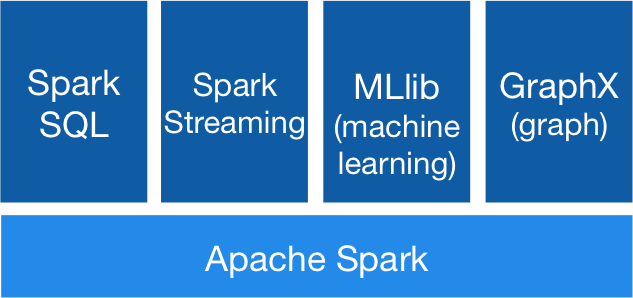

In [4]:
from IPython.display import Image
Image(filename='./images/spark-stack.png', width=600) 

# Enlaces útiles

[Co-creador Spark](https://people.csail.mit.edu/matei/)  
[Paper sobre RDD - (concepto fundamental en Spark)](https://www.usenix.org/system/files/conference/nsdi12/nsdi12-final138.pdf)  
[Resilient Distributed Datasets: A Fault-Tolerant Abstraction for In-Memory Cluster Computing](https://www.usenix.org/conference/nsdi12/technical-sessions/presentation/zaharia)  
[Sitio oficial](http://spark.apache.org/)  
[Canal en youtube](https://www.youtube.com/channel/UCRzsq7k4-kT-h3TDUBQ82-w)  
[Differences at shuffle side between Hadoop and Spark](http://people.eecs.berkeley.edu/~kubitron/courses/cs262a-F13/projects/reports/project16_report.pdf)
[Spark for Python Developers](https://www.packtpub.com/big-data-and-business-intelligence/spark-python-developers)  
[Learning Spark](http://shop.oreilly.com/product/0636920028512.do)  
[Advanced Analytics with Spark](http://shop.oreilly.com/product/0636920035091.do)  

# Instalación de Spark

La instalación no tiene grandes complicaciones basta con seguir la guía que se encuentra en este libro: [Spark for Python Developers](https://www.packtpub.com/big-data-and-business-intelligence/spark-python-developers) ó cualquier otro recurso disponible.

# Procesamiento de los datos

Una vez el data pump se encuentra descomprimido lo primero que se debe hacer bajo la filosofía Spark es crear la estructura RDD, en este caso se dispone de un conjunto de datos que contiene información bajo el formato JSON, la simplicidad de código sorprende porque realmente con muy pocas líneas de código se obtiene la creación de la estructura.

In [9]:
import json
# Creación del RDD
news_rdd = sc.textFile("/home/jasam/Downloads/contracts_data/contract_data_january_21_2016_cleaned.json")
# Operación Map -> por cada registro hacer una lectura JSON
news_json = news_rdd.map(lambda x: json.loads(x))

In [11]:
news_json.take(1)

[{'Correo Electrónico': 'MARIA.PALACIO@MEDELLIN.GOV.CO',
  'Creación de Proceso': '03 de November  de 2010  04:30 P.M.',
  'Cuantía Definitiva del Contrato': '$186,317,933     Peso Colombiano',
  'Cuantía a Contratar': '$186,317,933',
  'Departamento y Municipio de Ejecución': 'Antioquia : Medellín',
  'Detalle y Cantidad del Objeto a Contratar': 'PROMOVER EL FOMENTO DE LAS MUJERES RURALES DEL CORREGIMIENTO DE SAN SEBASTIAN DE PALMITAS -COMUNA 50- A TRAVES DE LA REALIZACIÓN DE ACTIVIDADES COMO ESTUDIO DE FACTIBILIDAD, DISEÑO DE UNA FIGURA DE PRODUCCIÓN Y COMERCIALIZACIÓN ASOCIADA  (MODELO EMPRESARIAL COMUNITARIO), PROGRAMACIÓN DE LA PRODUCCIÓN Y ESTABLECIMIENTO DE UNA ALIANZA PARA LA COMERCIALIZACIÓN DE PRODUCTOS DERIVADOS DE LAS ACTIVIDADES RURALES SEGÚN LAS DEFINE LA LEY DE MUJER RURAL, CONSIDERANDO EL ENTRENAMIENTO DE LIDERES Y BENEFICIANDO EL CORREGIMIENTO.',
  'Dirección Física del Contratista': 'CR 50 58 58 Municipio de Medellin',
  'Estado del Contrato': 'Liquidado',
  'Estado d

# Análisis del bloque de código anterior

**news_rdd = sc.textFile("/home/jasam/Downloads/contracts_data/contract_data_january_21_2016_cleaned.json")**

Creación de la estructura RDD (abstración primaria de Spark), recibe la ubicación del archivo JSON que contiene toda la información, aquí pueden ir también desde archivos planos hasta archivos en sistemas HDFS, el segundo parámetro 

Mas información sobre este método acá: http://spark.apache.org/docs/latest/programming-guide.html

**news_json = news_rdd.map(lambda x: json.loads(x))**

En spark se pueden llevar acabo dos tipos de procesos: acciones y transformaciones, en la linea de código anterior se realiza una transformación mediante el método map, quiere decir que por cada lectura de un registro en el datapump, se realizará una transformación a formato **JSON**, otro aspecto importante es la claúsula **lambda**, la cual permite incluir la invocación de una función de manera anónima, como se interpreta: x viene siendo cada registro del data pump, y lo que se quiere hacer es que a cada registro "x", se haga una lectura y carga a **JSON**.  es muy usual ver este constructo en las transformaciones con map, las transformaciones en Spark son con **patrón lazy**, es decir no se ejecutan inmediatamente, sino hasta que se invoque una acción.

[Acciones en spark](http://spark.apache.org/docs/latest/programming-guide.html#actions)  
[Transformaciones en Spark](http://spark.apache.org/docs/latest/programming-guide.html#transformations)  
[Acerca de la claúsula lambda](http://www.python-course.eu/lambda.php)  

**news_json.take(1)**

Por último se invoca una acción que significa retornar uno de los registros **JSON** del data pump, las acciones tienen una característica y es que estan implementadas bajo **patrón lazy**, es decir que en este momento es donde se ejecuta un **job de spark** bajo el **contexto spark iniciado** para operar con el **RDD**, para retornar la información solicitada, visualizando la estructura **JSON** del primer dato.

[Mas información transformaciones y acciones](https://trongkhoanguyenblog.wordpress.com/2014/11/27/understand-rdd-operations-transformations-and-actions/)